# Desert Island Lists

I happened upon a website run by one of my Sound Recording Technology professors that contains [a listing of Desert Island submissions](http://www.fermata.biz/desert.php3), as well as the opportunity to add your own. 

These lists answer the age-old question: "If you were stranded on a desert island and could only have ten albums to listen to (the island happens to have a 10-disc changer and a sweet listening room, no doubt designed by fermata), what would they be?"

Seeing this data I thought it would be interesting to examine its contents because these Desert Island lists will tend to have been produced by audio professionals (or aspiring professionals) and so will be an interesting source of music recommendations.

First we read and parse the data and then examine it in two ways:
1. Find the artists that appear most frequently among all the Desert Island lists
2. Consider how weighting artists' particular rank among the lists affects their overall ranking

## Cool Charts
* [Overall Leaders By Count](#count-leaders) -- which artists appeared most frequently in all lists?
* [Who Has The Most #1s?](#most-number-ones)
* [Leaders At Each Rank By Count](#rank-leaders)
* [Overall Leaders By Weight](#weight-leaders) -- which artists were ranked the highest most frequently?
* [Change In Ranking For Count-Leaders When Considering Weight Of Rank](#weight-based-changes) -- which artists appeared frequently at lower rankings or less frequently but at higher rankings?
* [Positional Gains Considering When Considering Rank](#positional-gains) -- people feel strongly about these less popular artists

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
font_size=20
fig_dimenions = (20, 10)

In [3]:
f = open('data.txt','r')
rows = []

def remove_the(s):
    # e.g. The Beatles and Beatles should reference the same artist
    if re.search('^The ', s): 
        return s[3:].strip()
    else:
        return s

def remove_last_dot(s):
    if s[-1] == '.':
        return s[:-1]
    else:
        return s
    
def fix_common_spelling_errors(s):
    if s in {'Dream Theatre'}:
        return 'Dream Theater'
    elif s in {'Astor Piazzola'}:
        return 'Astor Piazzolla'
    elif s in {'Led Zepplin'}:
        return 'Led Zeppelin'
    elif s in {'Jurrassic 5'}:
        return 'Jurassic 5'
    elif s in {"Guns N Roses"}:
        return "Guns N' Roses"
    elif s in {'Medeski Martin And Wood',
               'Medeski, Martin And Wood',
               'Medeski, Martin, And Wood'}:
        return 'Medeski Martin & Wood'
    elif s in {'Ludwig van Beethoven'}:
        return 'Beethoven'
    elif s in {'Notorious B', 'Notorous B'}:
        return 'Notorious B.I.G.' # this is a hack due to the artist regex below
    elif s in {'Queens Of The Stoneage'}:
        return 'Queens Of The Stone Age'
    elif s in {'Red Hot Chilli Peppers', 'Red Hot Chili Peppers'}:
        return 'Red Hot Chili Peppers'
    elif s in {'Simon & Garfunkle', 'Simon And Garfunkel'}:
        return 'Simon & Garfunkel'
    elif s in {'Stevie Ray Vaughn'}:
        return 'Stevie Ray Vaughan'
    elif s in {'Thelonius Monk'}:
        return 'Thelonious Monk'
    else:
        return s
    
def titleize(s):
    # e.g. Beatles and beatles should reference the same artist
    return s.strip().lower().title()

for i, line in enumerate(f):
    if line.strip() == "":
        continue
        
    r = "\.(.*)\,\s\""
    artist = re.search(r, line)
    r = "\"([^\"]*)\"" # albums appear in quotes
    album = re.search(r, line)
    if artist and album:
        rank = re.match('\d+', line)
        rank = int(rank[0])
        artist = remove_last_dot(fix_common_spelling_errors(remove_the(titleize(artist[1]))))
        album = remove_the(titleize(album[1]))
        rows.append([artist, album, rank])
    else:
        # currently not used
        name, year = line.split('/')
        name = re.sub("[^\w\s]", "", name).strip()
        year = None if year.strip() == '' else year.strip()
        
columns = ['artist', 'album','rank']
df = pd.DataFrame(columns=columns)

for i, row in enumerate(rows):
    df.loc[i] = row

<a id='count-leaders'></a>
# Artists With Most Mentions Across All Desert Island Lists
The simplest analysis we can do is to look at the number of artist mentions across all Desert Island lists. This should give a pretty good idea of which artists audio professionals tend to prefer. We see that The Beatles lead the pack, with Pink Floyd, Miles Davis, and Radiohead trailing behind.

In [4]:
count_by_artist = df.groupby('artist').size()
count_by_artist = count_by_artist.sort_values(ascending=False)

number_of_artists = count_by_artist.count()
number_of_mentions = count_by_artist.sum()
highest_single_percentage = format((count_by_artist['Beatles']/number_of_mentions * 100), '.1f')
leader_by_count = count_by_artist.head(1).reset_index()['artist'][0]
print(f'Total number of artists: {number_of_artists}')
print(f'Total number of ranked mentions: {number_of_mentions}')
print(f'{leader_by_count} have the highest single percentage of all mentions with {highest_single_percentage}%'
      + f' of entries across all rankings.\n1 in {round(100/float(highest_single_percentage))}'
      + f' of all Desert Island albums are {leader_by_count} albums.')

Total number of artists: 454
Total number of ranked mentions: 810
Beatles have the highest single percentage of all mentions with 4.3% of entries across all rankings.
1 in 23 of all Desert Island albums are Beatles albums.


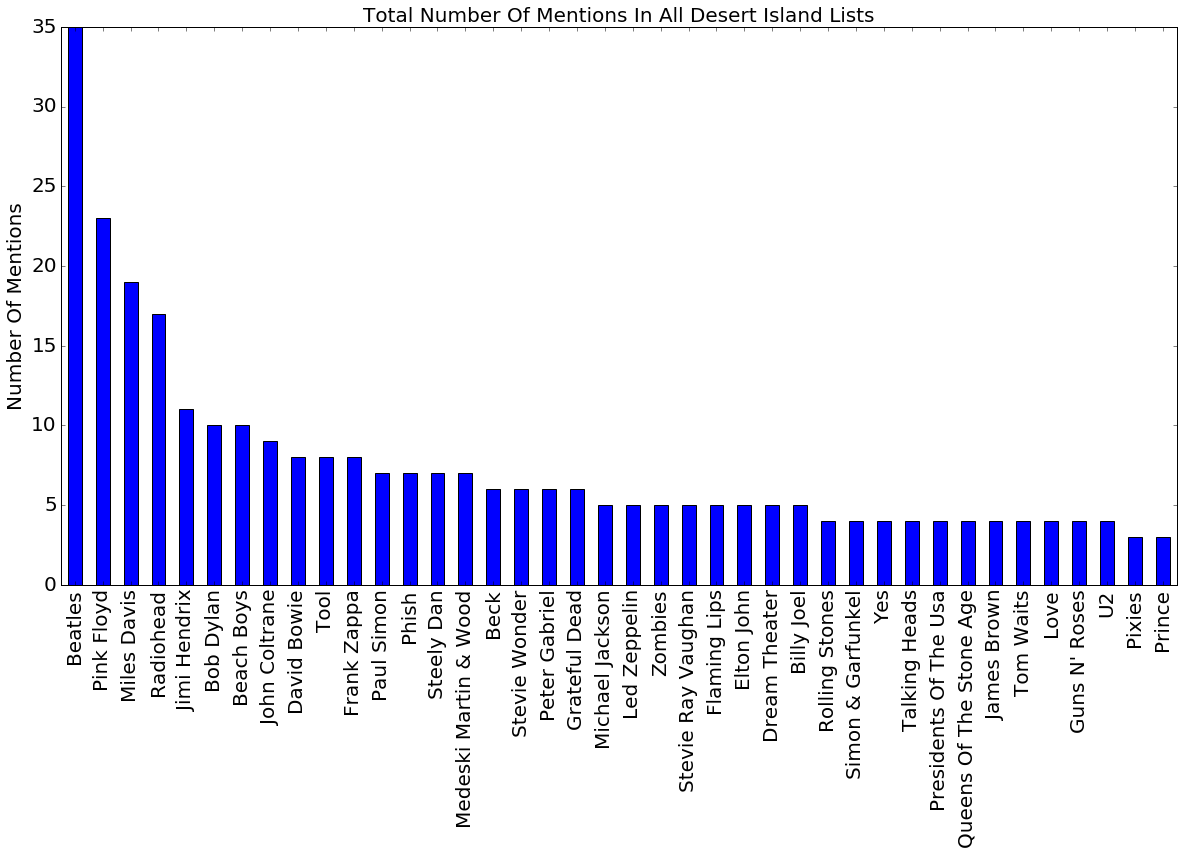

In [5]:
count_by_artist.head(40).plot.bar(figsize=fig_dimenions, fontsize=font_size)
plt.xlabel('')
plt.ylabel('Number Of Mentions', fontsize=font_size)
_ = plt.title("Total Number Of Mentions In All Desert Island Lists", fontsize=font_size)

<a id='most-number-ones'></a>
# Artists Ranked Most Frequently At Each Rank
We can see which artists had the most #1 rankings:

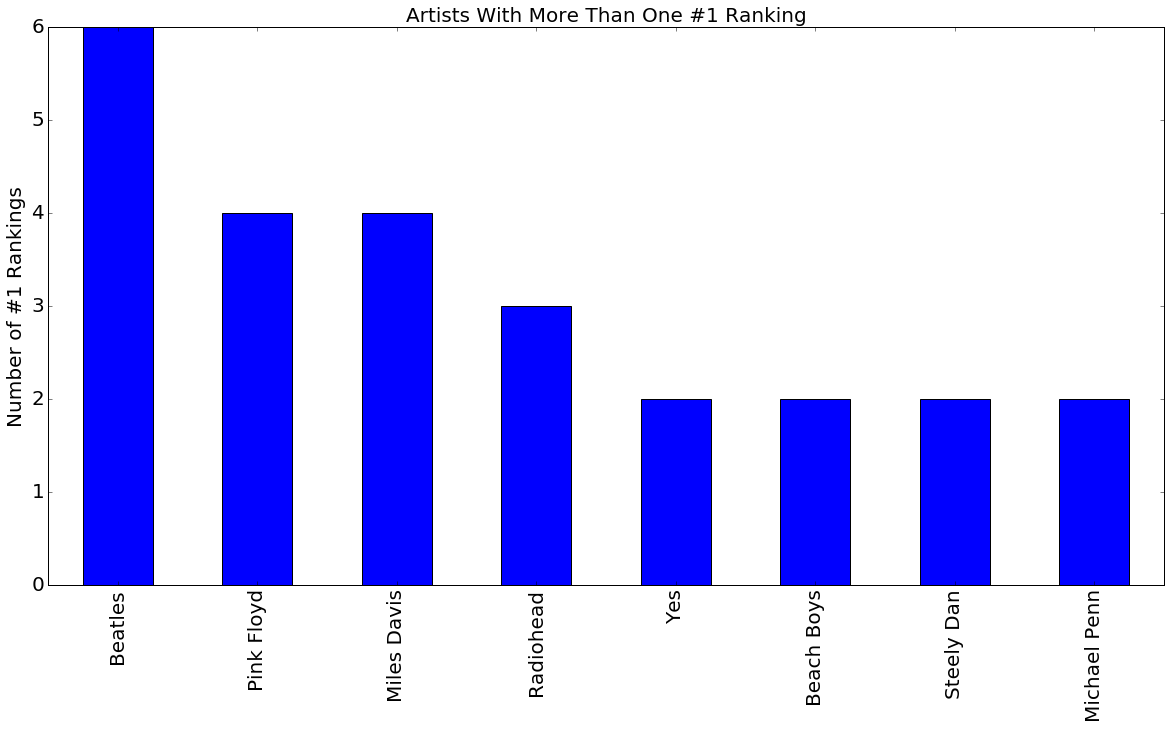

In [6]:
d = df[df['rank'] == 1].groupby('artist').size().sort_values(ascending=False)
artists_with_multiple_number_ones=d[d > 1]
artists_with_multiple_number_ones.plot.bar(figsize=fig_dimenions, fontsize=font_size)
plt.title('Artists With More Than One #1 Ranking', fontsize=font_size)
plt.ylabel('Number of #1 Rankings', fontsize=font_size)
_ = plt.xlabel('')

<a id='rank-leaders'></a>
We can also look at the rank distribution for each artist that leads at least one rank. For example, Miles Davis has the most #3 appearances, with 3, currently. We can see how many times Miles Davis was ranked at all positions. Similarly, Pink Floyd currently has the most #2 appearances, with 7 -- let's check out where Pink Floyd appeared across all rankings.

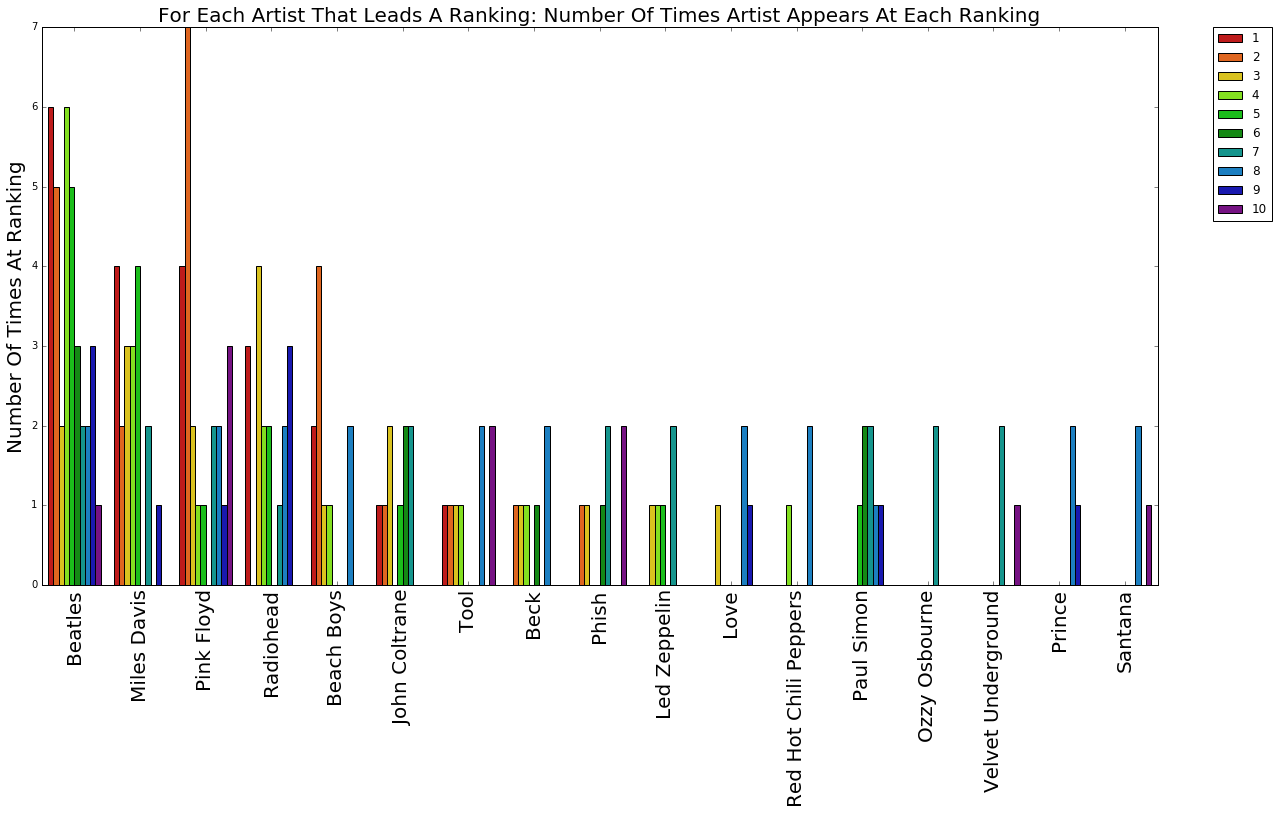

In [7]:
g = df.groupby(['rank','artist']).size().reset_index(name='count')
g.groupby(['rank'], sort=False)['count'].max()
idx = g.groupby(['rank'])['count'].transform(max) == g['count']
max_each_rank = g[idx]

g = df[df.artist.isin(max_each_rank.artist)].groupby(['rank','artist']).size().reset_index(name='count')

# sort by rank and count so that barplot has this order
g = g.sort_values(['rank', 'count'], ascending=[True, False])
fig, ax = plt.subplots(figsize=fig_dimenions)
ax = sns.barplot(data=g, x='artist', y='count', hue='rank', ax=ax, palette='spectral_r')

# Put the legend out of the figure
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=font_size)
ax.set_title('For Each Artist That Leads A Ranking: Number Of Times Artist Appears At Each Ranking', fontsize=font_size)
ax.set_xlabel('')
ax.set_ylabel('Number Of Times At Ranking', fontsize=font_size)
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<a id='weight-leaders'></a>
# Artists With Leading Weighted Scores
Looking at just the number of artist mentions across all Desert Island lists is interesting, but what about each artists' position in the rankings?

We need to give more points to higher-rated artists, and fewer points to lower-rated artists. We can achieve this by mapping each of the rankings from 1 to 10 with integer values equal to (11 - rank). Then we can see which artists had the highest rank-weighted rankings. The Beatles still lead the pack.


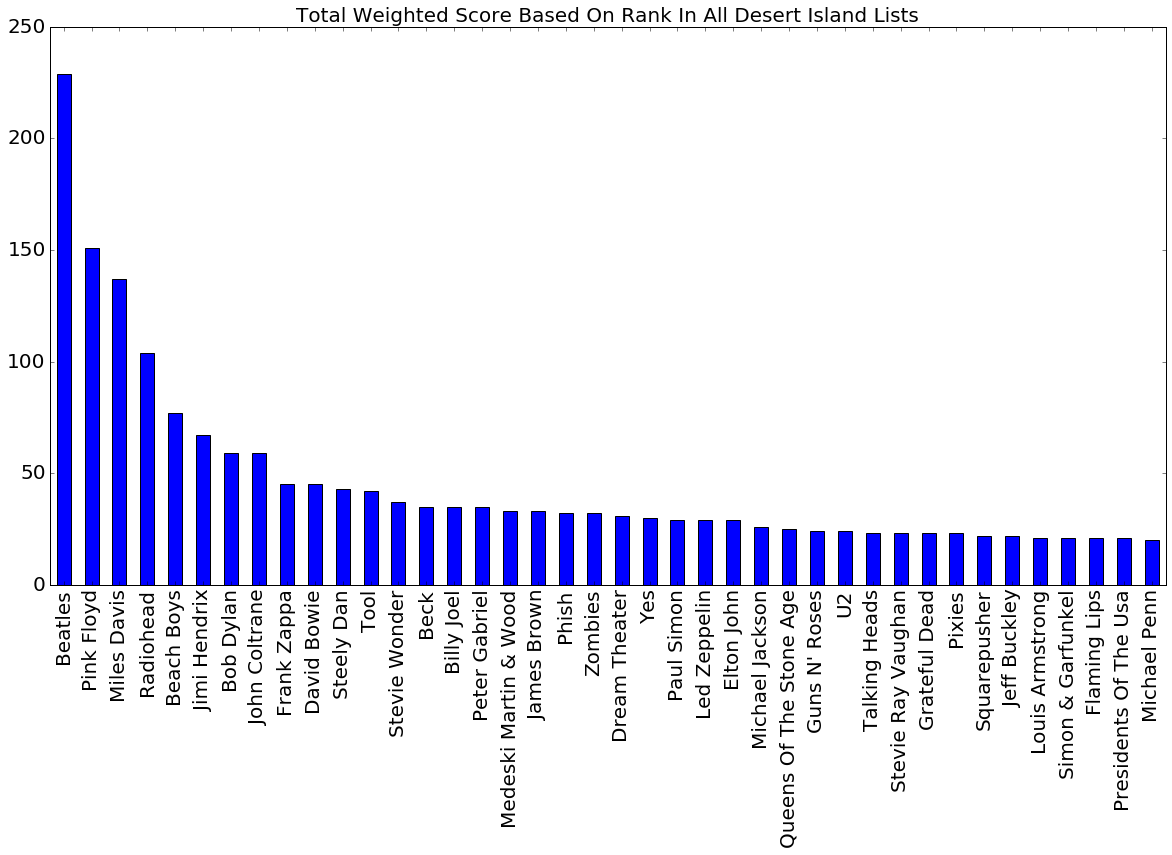

In [8]:
def weight(rank):
    return 11 - rank

all_artists = {}

for index, row in df.iterrows():
    a = row['artist']
    if a in all_artists:
        all_artists[a] += weight(row['rank'])
    else:
        all_artists[a] = weight(row['rank'])

weighted_by_ranking = pd.DataFrame.from_dict(all_artists, orient='index')
weighted_by_ranking.columns=['weight']
weighted_by_ranking = weighted_by_ranking.sort_values('weight', ascending=False)
weighted_by_ranking.head(40).plot.bar(fontsize=font_size, figsize=fig_dimenions)
plt.title("Total Weighted Score Based On Rank In All Desert Island Lists", fontsize=font_size)
plt.legend().set_visible(False)

<a id='weight-based-changes'></a>
# Change In Ranking For Count-Leaders When Considering Weight Of Rank
Let's consider all the artists who have as many mentions as at least 10% of the overall leader. Today, that leader is The Beatles and there are 38 such artists -- these are the most popular artists among all the Desert Island lists.

We can see which of these most popular artists tended to be ranked higher, and which, though popular, tended to be ranked lower. 

First we normalize all values to a scale of 0 to 1, where 1 represents the maximum possible value for weighted and count-based rankings -- currently the leader for both is The Beatles. So if an artist has count=0.5, that means the artist appeared in the Desert Island lists 50% as frequently as did The Beatles, and if the artist has weight=0.3 that means when considering rank-weighted rankings the artist has 30% of the score The Beatles have.

In the chart below, when an artist has a weight value greater than a corresponding count value it means that the although that particular artist tended to appear less frequently than the leader, the artist was ranked higher when it _did_ appear in Desert Island lists than did the leader. 

We saw earlier that The Beatles didn't change in rank -- they led both the count-based and weighted rankings so they appear with weight and count both equal to 1. It's interesting to note that John Coltrane also stayed in exactly the same place in the rankings, regardless of whether we consider the number of times he appears in the Desert Island lists or his position in the lists.

Among these most popular artists, James Brown had the biggest bump when considering where he was ranked among Desert Island lists, while Tom Waits lost the most ground -- while appearing a few times, he appeared in rather low Desert Island list position.

Finally, we can note that for the most part, the positional ranking of each of these most popular artists didn't drastically affect their ranking.

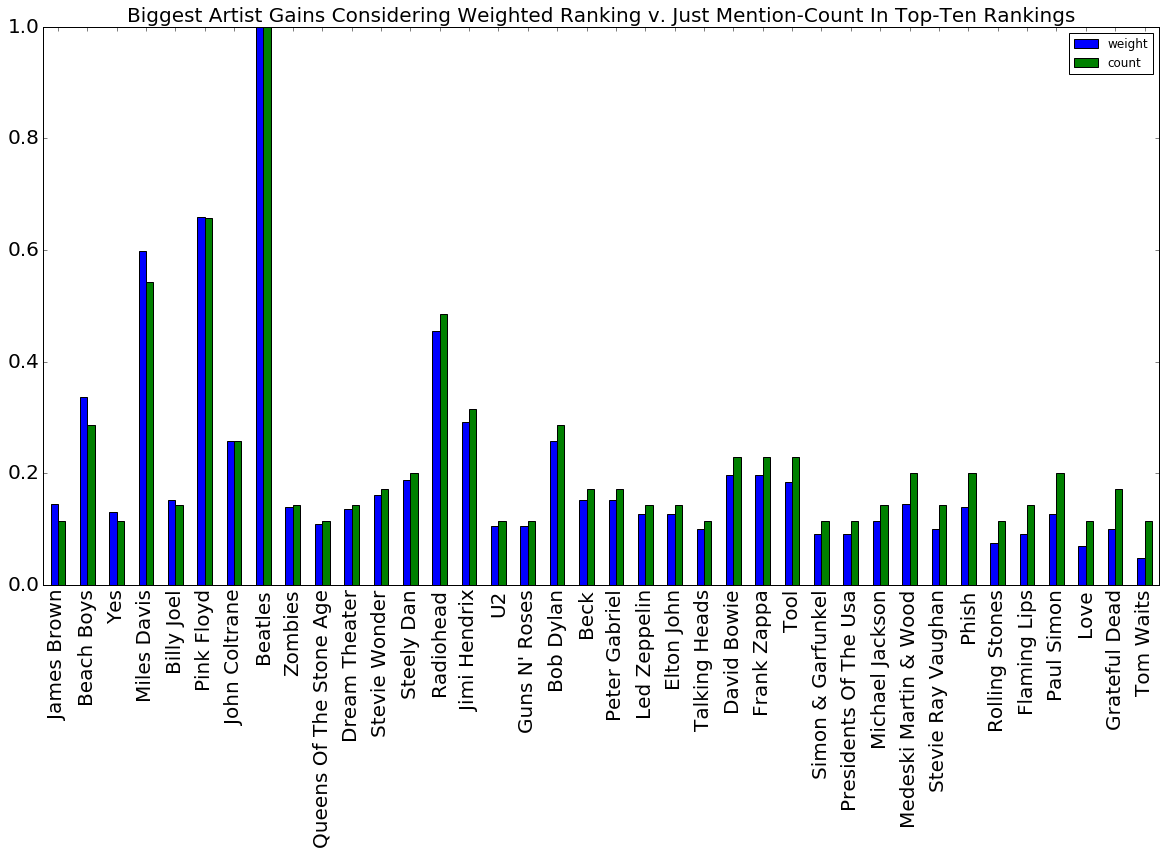

In [9]:
c = weighted_by_ranking.reset_index()
c.columns = ['artist', 'weight']
c['count'] = c.apply(lambda row: count_by_artist[row.artist], axis=1)
c = c.set_index('artist')
c['weight'] = c['weight'] / c['weight'].max()
c['count'] = c['count'] / c['count'].max()

gain_for_weight = c[c['count'] > 0.10].assign(
    diff = (c['weight'] - c['count'])/c['weight']
).sort_values(
    'diff', ascending=False
).drop('diff', axis=1)

gain_for_count = c[c['count'] > 0.10].assign(
    diff = (c['count'] - c['weight'])/c['weight']
).sort_values(
    'diff', ascending=False
).drop('diff', axis=1)

gain_for_weight.plot.bar(figsize=fig_dimenions, fontsize=font_size)
plt.xlabel('')
_ = plt.title(
    'Biggest Artist Gains Considering Weighted Ranking v. Just Mention-Count In Top-Ten Rankings',
    fontsize=font_size)

Another way to phrase that is to ask the question "which artist who are in the top 30 by count, are _not_ in the top 30 by weight?" Here we see some of the low performers in the above chart.

In [10]:
w = weighted_by_ranking.reset_index()
w.columns = ['artist', 'weight']
c = count_by_artist.reset_index()
c.columns = ['artist', 'count']
c[c['artist'].reset_index(drop=True) == w['artist'].reset_index(drop=True)]
l=30
landed_in_top_l_thanks_to_weighting = w.head(l)[~w.head(l).artist.isin(c.head(l).artist)]
landed_in_top_l_thanks_to_weighting
not_in_top_l_thanks_to_weighting = c.head(l)[~c.head(l).artist.isin(w.head(l).artist)]
not_in_top_l_thanks_to_weighting

,artist,count
18,Grateful Dead,6
22,Stevie Ray Vaughan,5
23,Flaming Lips,5
27,Rolling Stones,4
28,Simon & Garfunkel,4


<a id='positional-gains'></a>
# Biggest Positional Gains Considering When Considering Rank
Finally, we can also look at the absolute gain in rank among all the artists when considering their weighted rank vs just the number of times the artist appears across all Desert Island lists. If an artist has 250 positions to gain, they are obviously not going to be in any global top 10 lists, but appearing on this chart shows that when these artists _do_ appear in a Desert Island list, they are ranked relatively high, so whoever put them there feels rather strongly about these particular "outlier" picks.

I went and listened to <a href="https://en.wikipedia.org/wiki/Lunapark_(album)">Lunapark</a> based on this chart.

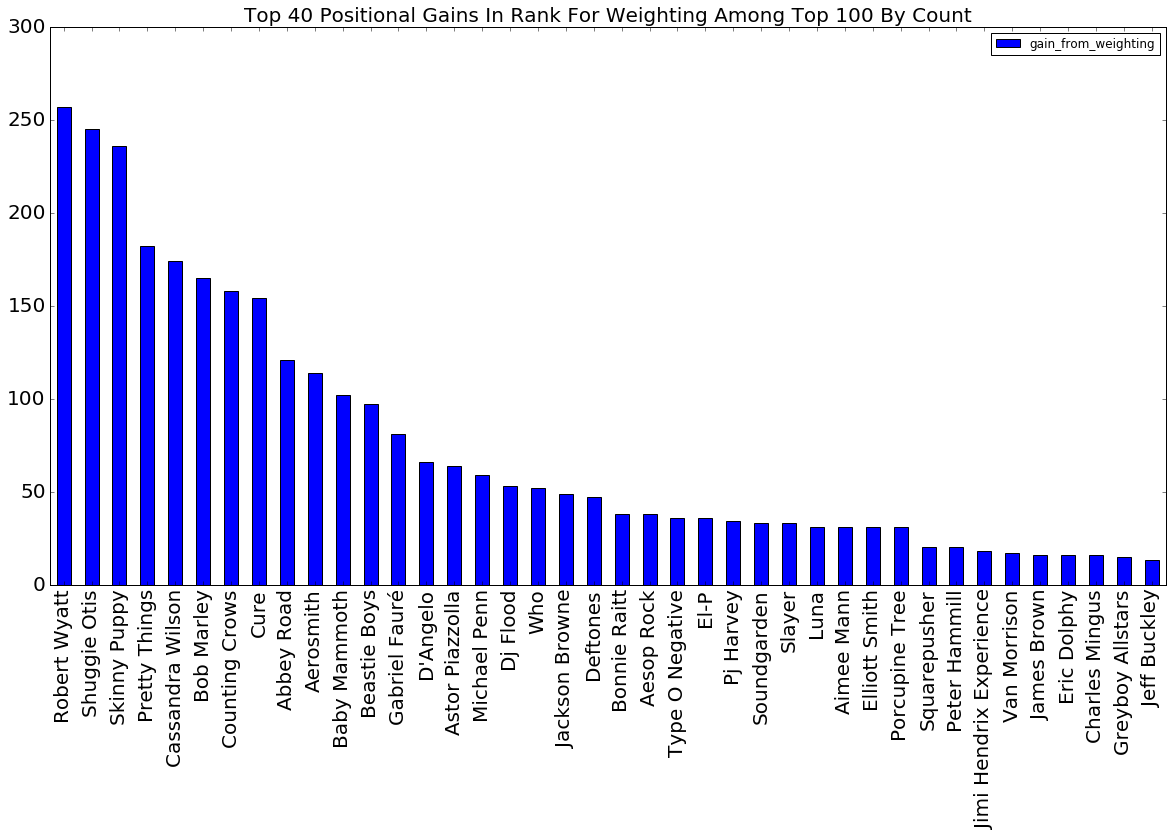

In [11]:
def index_in(artist, df):
    return df.index[df.artist == artist].tolist()[0]

def difference_in_rank(row, other_df):
    rank_in_this_df = row.name # https://stackoverflow.com/a/26658301/3833166
    rank_in_other_df = index_in(row.artist, other_df)
    
    return rank_in_other_df - rank_in_this_df

a = weighted_by_ranking.reset_index()
a.columns = ['artist', 'weight']
l = lambda row: difference_in_rank(row, count_by_artist.reset_index())
a['gain_from_weighting'] = a.apply(l, axis=1)
for_plot = a.head(100).sort_values(
    'gain_from_weighting', 
    ascending=False
).head(40)[['artist', 'gain_from_weighting']].set_index('artist')
for_plot.plot.bar(figsize=fig_dimenions, fontsize=font_size)
plt.xlabel('')
_ = plt.title('Top 40 Positional Gains In Rank For Weighting Among Top 100 By Count', fontsize=20)